#                                   **  Assignment 6A** 
#                                     =================

Name : Nihar Kanungo Batch : 6:30 AM , Monday

Background :
==============
This is a Image Recognition program which makes use of the Cifar 10 preprocessed dataset . The Code uses one of the most popular Tensorflow API Keras to perform the operations .It's a supervised Computer Vision problem.

We have been using MNIST as our first dataset to perform experiments due to various reasons , however we also need to work on complex datasets to see how our model generalizes on complex data structures . CIFAR 10 is one of the complex datsets readily available for us to experiment on .


There are 10 different networks defined in this file . Each network defined in this file is an Experiment over it's Predecessor. The first network is the baseline and the other networks are expected to beat the validation accuracy of it , at the same time having a check on the number of parameters 


Input
==========
1) 60000 images (10 Class)

2) The Images are already segreegated as Train and Test Data with the respective target values

Environment

Development - Colab GPU , Jupyter Notebook
Repository : Github

Algorithm
=========
Linear Model 
Convolutional Neural Network (2D) - Gray Scale images
Maxpooling 
Softmax Activation function
loss Function : Categorical Crossentropy
Optimizer=Adam, SGD
Metrics=accuracy
Batch Normalization
Drop Out 
Image Normalization
Customized Loss function (Loss function  + L2 Regularization)


Parameters
============
Batch Size - Variable 
Epochs - Variable
Kernel Size - Variable (Advisable to use 3 * 3 , at the same time not taking the image very less in size)
Number of Kernels - Variable 
Learning Rate
regularization coefficient


Conditions
==========
1. remove dense
2. add layers required to reach RF
3. fix kernel scaleup and down (1x1)
4. see if all dropouts are properly placed
5. Get accuracy more than the base accuracy in less number 100 epochs. 
6. Should use only Conv2D
7. Should not have applied Maxpooling before 2-4 layers of the conversion into number of classes (10 in this case)
8. Maxpooling should be applied on receptive field of at least 5 x 5 or 7 x 7
9. Activation function should be relu on conv 2D
10. Image Normalization should be used first
11. L2 regularization should not be added to each layer
12. Batch Normalization should be used before the Activation function

Expected Result
==================
1.To get >= the accuracy of the base model



# Import all Libraries 

In [0]:
from keras import backend as K
import time
import matplotlib.pyplot as plt
import numpy as np
% matplotlib inline
np.random.seed(2017) 
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense, Dropout
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils

* Load the CIFAR 10 images into the notebook 
===========================================

The **CIFAR-10 dataset** (Canadian Institute For Advanced Research) is a collection of images that are commonly used to train machine learning and computer vision algorithms. It is one of the most widely used datasets for machine learning research. The CIFAR-10 dataset contains 60,000 32x32 color images in 10 different classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. 
Computer algorithms for recognizing objects in photos often learn by example. CIFAR-10 is a set of images that can be used to teach a computer how to recognize objects. Since the images in CIFAR-10 are low-resolution (32x32), this dataset can allow researchers to quickly try different algorithms to see what works. Various kinds of convolutional neural networks tend to be the best at recognizing the images in CIFAR-10.
CIFAR-10 is a labeled subset of the 80 million tiny images dataset. When the dataset was created, students were paid to label all of the images. 

Source : wikipedia

In [2]:
from keras.datasets import cifar10
(train_features, train_labels), (test_features, test_labels) = cifar10.load_data()
num_train, img_channels, img_rows, img_cols =  train_features.shape
num_test, _, _, _ =  test_features.shape
num_classes = len(np.unique(train_labels))

170500096/170498071 [==============================] - 2s 0us/step


Display the Class outputs
=============================
Looking at the images we can understand that it's not a simple dataset. Hence lot of care must be taken to generalize this dataset and get a good accuracy

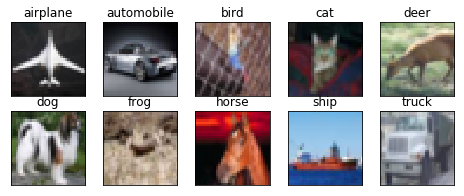

In [3]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']
fig = plt.figure(figsize=(8,3))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(train_labels[:]==i)[0]
    features_idx = train_features[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = features_idx[img_num]
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

Function to define the Model history and Plot chart
====================================================
The Parameters of the model is a key information to quickly visualize how the model performed . Analysis of the 

1. Training Accuracy vs Validation Accuracy       and

2. Training Loss vs Validation Loss 

would give a great understanding of the model performance

Writting a custom function helps us to modify or customize the information based on our need. We are building these functions so that we can customize more in future 

In [0]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# Function to define the Accuracy of the model

This custom function will help us i future to design the Accuracy based on our need


In [0]:
def accuracy(test_x, test_y, model):
    result = model.predict(test_x)
    predicted_class = np.argmax(result, axis=1)
    true_class = np.argmax(test_y, axis=1)
    num_correct = np.sum(predicted_class == true_class) 
    accuracy = float(num_correct)/result.shape[0]
    return (accuracy * 100)

Standardize the data by diving it by 255
==========================================

In [0]:
train_features = train_features.astype('float32')/255
test_features = test_features.astype('float32')/255
# convert class labels to binary class labels
train_labels = np_utils.to_categorical(train_labels, num_classes)
test_labels = np_utils.to_categorical(test_labels, num_classes)

# Define the Base Model 

Let's remember that it's not a good model as it uses 

1. Dense Layers at the end which increased the parameters very high

2. No Normalization methods used

3. Improper use of Drop out 

4. Transition block has not been used 

5. Dropout of 50% used just before the softmax layer 




In [10]:
# Define the model
model = Sequential()
model.add(Convolution2D(48, 3, 3, border_mode='same', input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(48, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(96, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(96, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(192, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(192, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(48, (3, 3))`
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(96, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(192, (3, 3), padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` 

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_224 (Conv2D)          (None, 32, 32, 48)        1344      
_________________________________________________________________
activation_243 (Activation)  (None, 32, 32, 48)        0         
_________________________________________________________________
conv2d_225 (Conv2D)          (None, 30, 30, 48)        20784     
_________________________________________________________________
activation_244 (Activation)  (None, 30, 30, 48)        0         
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 15, 15, 48)        0         
_________________________________________________________________
dropout_149 (Dropout)        (None, 15, 15, 48)        0         
_________________________________________________________________
conv2d_226 (Conv2D)          (None, 15, 15, 96)        41568     
__________

# The Model Training 

1. The Images are normalized before training

2. Image Augmentation techniques not used


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`
  if sys.path[0] == '':


Epoch 1/100
390/390 [==============================] - 36s 92ms/step - loss: 1.8544 - acc: 0.2893 - val_loss: 1.5033 - val_acc: 0.4511
Epoch 2/100
390/390 [==============================] - 24s 60ms/step - loss: 1.3548 - acc: 0.5099 - val_loss: 1.1319 - val_acc: 0.5872
Epoch 3/100
390/390 [==============================] - 23s 60ms/step - loss: 1.1279 - acc: 0.6026 - val_loss: 0.9495 - val_acc: 0.6596
Epoch 4/100
390/390 [==============================] - 23s 60ms/step - loss: 0.9716 - acc: 0.6590 - val_loss: 0.9069 - val_acc: 0.6880
Epoch 5/100
390/390 [==============================] - 24s 61ms/step - loss: 0.8768 - acc: 0.6959 - val_loss: 0.7791 - val_acc: 0.7293
Epoch 6/100
390/390 [==============================] - 24s 61ms/step - loss: 0.8024 - acc: 0.7235 - val_loss: 0.7468 - val_acc: 0.7418
Epoch 7/100
390/390 [==============================] - 24s 61ms/step - loss: 0.7485 - acc: 0.7406 - val_loss: 0.7124 - val_acc: 0.7499
Epoch 8/100
390/390 [==============================] - 

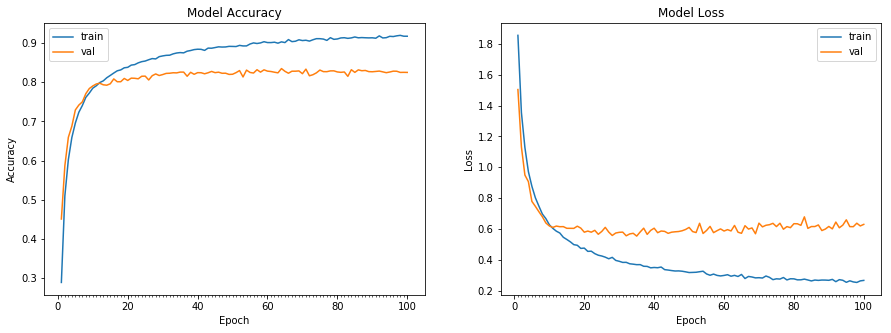

Accuracy on test data is: 82.51


In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome 
========

The highest Validation accuracy of the model  is found to be 83.49 % .

Now let's analyze the graphs and see how it looks

1. The Models were giving similar accuracy on both training and validation sets till epoch 15. The model probably started over training after that .

2. Towards the end there is almost a 10% difference between the training and validation accuracy 

3. The same pattern is seen on the loss as well. It was almost similar till 15th Epoch

**Now the Question is** 

Did the model over trained ? How do we know that ? If we see the example of MNIST then we will definitely think that it's over trained and a lot . But let's recall that CIFAR 10 is not a simple data set .Again the concept of over training is subjective . So let's park this topic for a while until we run all the networks and see their performance as well


Experiment No -1 
====================

Why am I calling it as experiment ? The reason behind calling it as expriment is that i am going to have many different combinations of methods on top of the base model . At the same time I will keep going even though i hit my expected result at the first network . 

The Following methods are applied to the network defined above in order to increase the accuracy of the model . At the same time keeping the number of parameters lower .

1. Added Batch Normalization

![](images/bn.jpg)

2. Added Small Dropouts at the end 

![](images/do.png)

3. Added few transition blocks (The following image is a good example of how it works . Source : Andrew N's teaching material)

![](images/an.jpg)

4. Removed Dense layers

5. changed the optimizer of SGD (Here on we may use SGD a lot as this seems to be the best till date and many of the state of the art models are using it)

![](images/bp.png)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3), padding="same")`
  from ipykernel import kernelapp as app
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(256, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: UserWarning: Up

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_230 (Conv2D)          (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_214 (Bat (None, 32, 32, 32)        128       
_________________________________________________________________
activation_251 (Activation)  (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_231 (Conv2D)          (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_215 (Bat (None, 30, 30, 64)        256       
_________________________________________________________________
activation_252 (Activation)  (None, 30, 30, 64)        0         
_________________________________________________________________
max_pooling2d_51 (MaxPooling (None, 15, 15, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:90: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 45s 116ms/step - loss: 1.9746 - acc: 0.2992 - val_loss: 1.7248 - val_acc: 0.4075
Epoch 2/100
390/390 [==============================] - 32s 81ms/step - loss: 1.6649 - acc: 0.4319 - val_loss: 1.5630 - val_acc: 0.4672
Epoch 3/100
390/390 [==============================] - 32s 81ms/step - loss: 1.5265 - acc: 0.4844 - val_loss: 1.4321 - val_acc: 0.5222
Epoch 4/100
390/390 [==============================] - 32s 81ms/step - loss: 1.4176 - acc: 0.5268 - val_loss: 1.3980 - val_acc: 0.5368
Epoch 5/100
390/390 [==============================] - 32s 81ms/step - loss: 1.3273 - acc: 0.5581 - val_loss: 1.4884 - val_acc: 0.4941
Epoch 6/100
390/390 [==============================] - 32s 81ms/step - loss: 1.2498 - acc: 0.5825 - val_loss: 1.2620 - val_acc: 0.5680
Epoch 7/100
390/390 [==============================] - 32s 81ms/step - loss: 1.1846 - acc: 0.6046 - val_loss: 1.3125 - val_acc: 0.5546
Epoch 8/100
390/390 [==============================] -

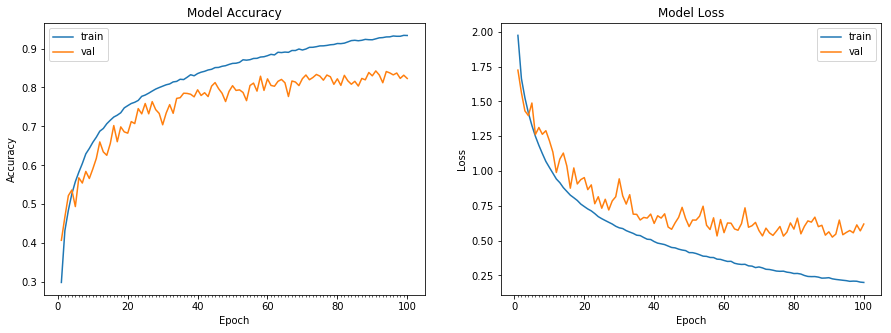

Accuracy on test data is: 82.32


In [43]:
# Define the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))   # 32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                                                # 30
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2)))                                         # 15
model.add(Dropout(0.25))


model.add(Convolution2D(128, 3, 3, border_mode='same'))                            # 15
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Convolution2D(256, 3, 3))                                               # 13
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Convolution2D(32, 1, 1))                                                # 13
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Convolution2D(64, 3, 3))                                                # 11
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=(2, 2)))                                         # 5
model.add(Dropout(0.25))



model.add(Convolution2D(128, 3, 3, border_mode='same'))                           # 5
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(32, 1, 1, border_mode='same'))                           # 5
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Convolution2D(64, 5, 5))                                               # 1
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))

model.add(Convolution2D(10, 1, 1, border_mode='same'))                           # 1
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())
#model.add(Dense(512))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
#model.add(Dense(256))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])


#
#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))


Outcome 
========

The highest Validation accuracy of the model  is found to be 84.26 % . (Boom - We achieved it)

Are we happy ? hmmm , I don't think so . Even though we achieved but the margin is not that great.Let's explore more and see if we can overshoot this .

But before that let's analyze the graphs and see how it looks

1. The validation accuracy curve is not smooth. There are lot of spikes and at the same time we can hardly see any time that the training accuracy and validation accuracy is in similar range . 

2. Towards the end there is almost a 10-11% difference between the training and validation accuracy 

3. The same pattern is seen on the loss as well. The Validation loss curve is also not smooth


What that means ? Did we create a model better than previous one or not ? Did the model over trained ? How do we know that ? 
I am confused now .

again like last time let's park this topic for a while until we run all the networks and see their performance as well


Experiment No -2
=====================


The Following methods are applied to the network defined above in order to increase the accuracy of the model . At the same time keeping the number of parameters lower .

1. Added Batch Normalization

2. Added Small Dropouts at the end

3. More numbers of transition blocks added 

changed the optimizer back to adam (you may not agree to it , but i am just experimenting)






/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0827 00:53:08.181780 139817643452288 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 AP

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
activation_25 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
activation_26 (Activation)   (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 28, 28, 128)       73856     
__________

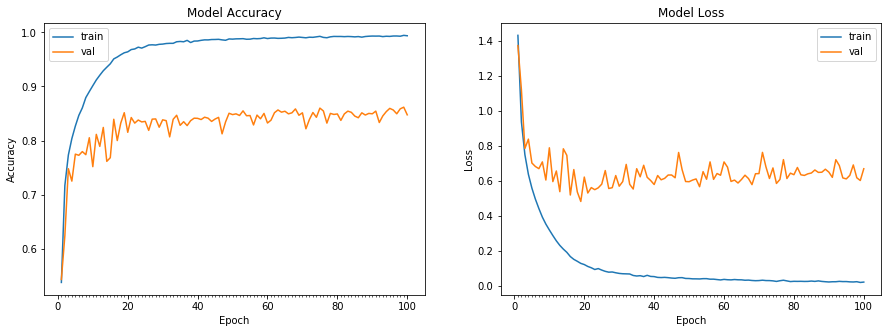

Accuracy on test data is: 84.77


In [11]:
# Define the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
model.add(Dropout(0.25))

model.add(Convolution2D(32, 3, 3, border_mode='same')) #14
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3,border_mode='same'))   #14
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(128, 3, 3,border_mode='same'))   #14
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(256, 3, 3))   # 12
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=(2, 2))) # 6
model.add(Dropout(0.25))


model.add(Convolution2D(32, 3, 3, border_mode='same')) #6
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Convolution2D(10, 6, 6))   #1
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Flatten())

model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
========

Did you see that , The highest Validation accuracy of the model is found to be 86.18 % . (Again We achieved it and this time there are multiple epochs where we crossed validation accuracy of 86 %)

Are we happy ?  Probably not as while checking the validation accuracy i had a quick look at the graphs and from the first look it didn't look that great 

So let's analyze the graphs and see how it looks. Fingures crossed

The validation accuracy curve is little bit more smoother than the last one . There are lot of spikes but the variation is not high . But when i see the training accuracy chart i became upset. There is a huge gap between the training accuracy and validation accuracy . That means the model is certainly over trained and the training accuracy crossed 99%. That means the validation accuracy of the model has very less scope to move up.

There is almost a 15% difference between the training and validation accuracy

The same pattern is seen on the loss as well. The Validation loss is very high compared to the training loss

So as usual lets move on towards our next experiment 


Experiment No -3
=====================

So when we think over over training what comes to our mind first ? Yes that's dropout . We didn't fix the dropouts properly in the last model . So we are going to 

1. Fix the dropout layers properly by adding a small amount (10%) drop out after each convolution layer 


Let's see if it helps us to generalize by reducing the gap between the training and validation parameters 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Ker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_28 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_10 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_18 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
activation_35 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_19 (Dropout)         (None, 30, 30, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:70: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 40s 102ms/step - loss: 1.5596 - acc: 0.4842 - val_loss: 1.4694 - val_acc: 0.5211
Epoch 2/100
390/390 [==============================] - 37s 96ms/step - loss: 1.1002 - acc: 0.6575 - val_loss: 1.1653 - val_acc: 0.6256
Epoch 3/100
390/390 [==============================] - 37s 96ms/step - loss: 0.9077 - acc: 0.7138 - val_loss: 0.9291 - val_acc: 0.6984
Epoch 4/100
390/390 [==============================] - 38s 96ms/step - loss: 0.7935 - acc: 0.7483 - val_loss: 0.9974 - val_acc: 0.6622
Epoch 5/100
390/390 [==============================] - 38s 96ms/step - loss: 0.7180 - acc: 0.7705 - val_loss: 0.7874 - val_acc: 0.7364
Epoch 6/100
390/390 [==============================] - 38s 96ms/step - loss: 0.6557 - acc: 0.7890 - val_loss: 0.8930 - val_acc: 0.7009
Epoch 7/100
390/390 [==============================] - 37s 96ms/step - loss: 0.6175 - acc: 0.7981 - val_loss: 0.7348 - val_acc: 0.7582
Epoch 8/100
390/390 [==============================] -

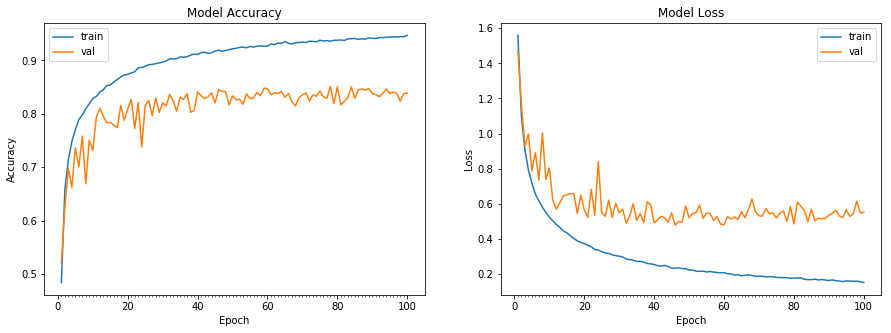

Accuracy on test data is: 83.85


In [12]:
# Define the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
model.add(Dropout(0.1))

model.add(Convolution2D(32, 3, 3, border_mode='same')) #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))   # 12
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=(2, 2))) # 6
model.add(Dropout(0.1))


model.add(Convolution2D(32, 3, 3, border_mode='same')) #6
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(10, 6, 6))   #1
model.add(BatchNormalization())
model.add(Activation('relu'))


model.add(Flatten())

model.add(Activation('softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
========

What did you observe ? The model has generalized a little definitely .Before that let's find out what's the highest Validation accuracy of the model. It seems to be  85.15 % . 



So let's analyze the graphs and see how it looks. Fingures crossed

The validation accuracy curve is little bit more smoother than the last one . There are lot of spikes but the variation is not high . It's also closer to the training accuracy to some extent but not a great improvement overall as we almost got the similar gap in our Experiment No 1 . The only difference here is that the validation accuracy is little higher than Experiment-1 .

The difference between the training and validation accuracy is almost 10% which is not that great 

Now i am completely confused , so what's left ? Expriment More 


Experiment No -4
=====================


This experiment is to find out the impact of padding to the network. We are not hopeful that this would solve the purpose of over training or give us more validation accuracy . However we are experimenting this to find out the impact of padding on the network. This may help us to understand when to use padding and when not .

So we modified the network to update 

1. Padding in a lot of spaces . The below diagram will help understanding how padding works 

![](images/padding.png)

2. Changed the Optimizer to sgd again to see if it gives us a better validation accuracy
3. Used Transition block properly


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Ker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_17 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_26 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
activation_43 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_18 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_27 (Dropout)         (None, 30, 30, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:91: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 48s 124ms/step - loss: 2.0451 - acc: 0.2602 - val_loss: 2.1463 - val_acc: 0.1939
Epoch 2/100
390/390 [==============================] - 45s 116ms/step - loss: 1.7658 - acc: 0.3813 - val_loss: 2.0457 - val_acc: 0.2584
Epoch 3/100
390/390 [==============================] - 45s 116ms/step - loss: 1.6252 - acc: 0.4378 - val_loss: 1.7125 - val_acc: 0.3964
Epoch 4/100
390/390 [==============================] - 45s 116ms/step - loss: 1.5147 - acc: 0.4819 - val_loss: 1.7285 - val_acc: 0.3895
Epoch 5/100
390/390 [==============================] - 45s 116ms/step - loss: 1.4291 - acc: 0.5108 - val_loss: 1.8193 - val_acc: 0.3590
Epoch 6/100
390/390 [==============================] - 45s 116ms/step - loss: 1.3574 - acc: 0.5369 - val_loss: 1.7266 - val_acc: 0.3944
Epoch 7/100
390/390 [==============================] - 45s 115ms/step - loss: 1.2875 - acc: 0.5627 - val_loss: 1.5537 - val_acc: 0.4440
Epoch 8/100
390/390 [===========================

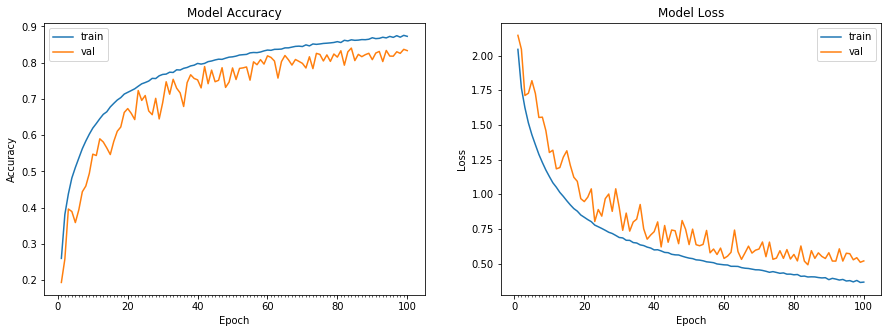

Accuracy on test data is: 83.32


In [19]:
# Define the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
model.add(Dropout(0.1))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(32, 3, 3, border_mode='same')) #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3,border_mode='same'))   #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3,border_mode='same'))   #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2))) # 7
model.add(Dropout(0.1))

model.add(Convolution2D(64, 1, 1)) #7
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #7
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))   #5
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(32, 1, 1)) #5
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(10, 5, 5))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
=========

Boom ! Expect the Unexpected 

Did you observe that it actually solved the problem of over training to a great extent ? So what solved it ?

Is it the padding ? or the careful use of transition block ? or a combination of both ? 

We will try to figure this out . 

But wait ! what's the validation accuracy. Did SGD did any good for us . Let's see 

The highest Validation accuracy of the model. It seems to be 84.02 % .This is more than our requirement but marginally . We can stop  here but i am deciding to keep experimenting . We may not find anything really great , but we will at least find out what are those which can't help us a lot . It's like the kernels which tries to think a lot after the dropout layer .

Experiment No -5
==================

I got a doubt on the previous network. SO let's run it again with a small change . 
This time we will not use the transition block to reduce the channel to 10, rather drop the channels to 10 without using it . Let's see if it's giving us any bad result , if so then how much 


1. dropped from 128 to 10 directly 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: UserWarning: Update your `Conv2D` call to the Ker

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_47 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_29 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_39 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
activation_56 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_30 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_40 (Dropout)         (None, 30, 30, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:86: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 54s 139ms/step - loss: 1.6485 - acc: 0.4396 - val_loss: 1.7142 - val_acc: 0.3886
Epoch 2/100
390/390 [==============================] - 50s 127ms/step - loss: 1.1855 - acc: 0.6164 - val_loss: 1.2049 - val_acc: 0.5934
Epoch 3/100
390/390 [==============================] - 50s 128ms/step - loss: 0.9609 - acc: 0.6897 - val_loss: 0.9270 - val_acc: 0.6957
Epoch 4/100
390/390 [==============================] - 50s 128ms/step - loss: 0.8216 - acc: 0.7352 - val_loss: 0.9380 - val_acc: 0.6872
Epoch 5/100
390/390 [==============================] - 50s 127ms/step - loss: 0.7324 - acc: 0.7643 - val_loss: 0.7234 - val_acc: 0.7623
Epoch 6/100
390/390 [==============================] - 50s 128ms/step - loss: 0.6696 - acc: 0.7836 - val_loss: 0.7091 - val_acc: 0.7573
Epoch 7/100
390/390 [==============================] - 50s 128ms/step - loss: 0.6182 - acc: 0.7980 - val_loss: 0.7278 - val_acc: 0.7545
Epoch 8/100
390/390 [===========================

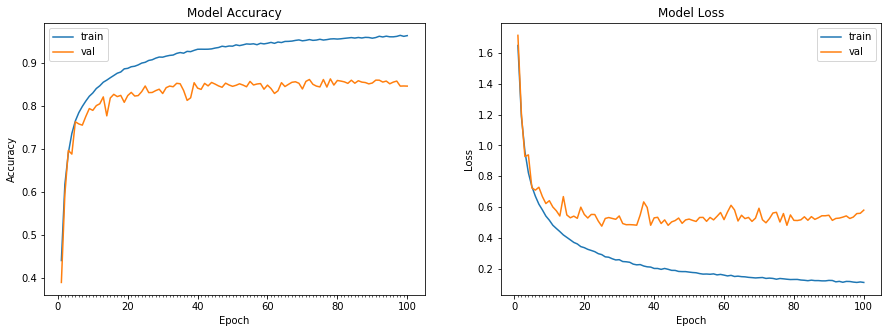

Accuracy on test data is: 84.53


In [20]:
# Define the model
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
model.add(Dropout(0.25))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(32, 3, 3, border_mode='same')) #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3,border_mode='same'))   #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3,border_mode='same'))   #14
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2))) # 7
model.add(Dropout(0.25))

model.add(Convolution2D(64, 1, 1)) #7
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #7
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))   #5
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(10, 5, 5))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
========

The validation Accuracy of the model increased to 86.81 %  and i used adam optimizer in this model . But the graphs are not happy . It again showed over training which was resolved to some extent in the previous network .Loss curve also followed the same path as accuracy curve .

So what's the best combination of methods to be used to get the 
1. Higher validation accuracy

2. A good fit model

and 

3. With less number of parameters

We may not find one but what's wrong in experimenting




Experiment No -6
==================
Let's keep everything the same , but as it's all about over training , let me add a little more dropout to each step and see how the model behaves .

So we added 25% dropout to each layer . it's huge ? may be , let's see how the network behaves

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_58 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_40 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_51 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
activation_68 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_41 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_52 (Dropout)         (None, 30, 30, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 45s 115ms/step - loss: 1.8705 - acc: 0.3415 - val_loss: 2.9933 - val_acc: 0.1417
Epoch 2/100
390/390 [==============================] - 40s 104ms/step - loss: 1.4486 - acc: 0.5073 - val_loss: 2.0914 - val_acc: 0.2699
Epoch 3/100
390/390 [==============================] - 41s 104ms/step - loss: 1.2351 - acc: 0.5840 - val_loss: 1.5452 - val_acc: 0.4584
Epoch 4/100
390/390 [==============================] - 40s 103ms/step - loss: 1.1044 - acc: 0.6271 - val_loss: 1.3058 - val_acc: 0.5434
Epoch 5/100
390/390 [==============================] - 40s 104ms/step - loss: 1.0216 - acc: 0.6532 - val_loss: 1.3848 - val_acc: 0.5189
Epoch 6/100
390/390 [==============================] - 40s 103ms/step - loss: 0.9665 - acc: 0.6700 - val_loss: 1.6030 - val_acc: 0.4604
Epoch 7/100
390/390 [==============================] - 40s 104ms/step - loss: 0.9263 - acc: 0.6835 - val_loss: 1.3487 - val_acc: 0.5317
Epoch 8/100
390/390 [===========================

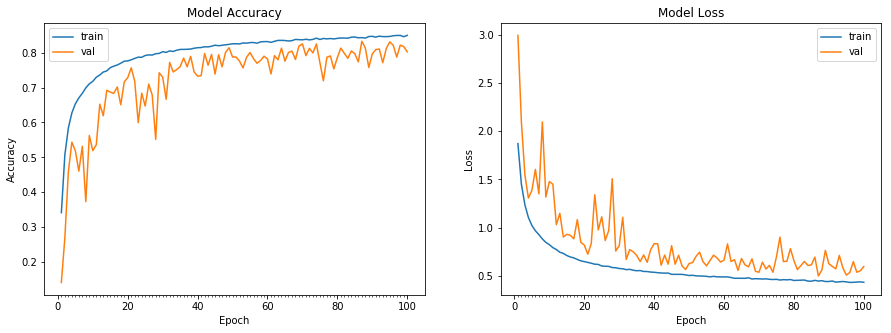

Accuracy on test data is: 80.20


In [21]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
model.add(Dropout(0.25))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #14
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # 7
model.add(Dropout(0.25))

model.add(Convolution2D(32, 1, 1)) #7
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #7
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))   #5
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(32, 1, 1)) #5
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Activation('relu'))

model.add(Convolution2D(10, 5, 5))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
========

The Model definitely generalized very well . That's clearly visible when we look at teh charts . The validation parameters has some spikes but it was almost in the range of the training parameters .

1. The difference between the training and validation accuracy is around 2-3 % 

2. The difference in loss is also around 0.2 

But did we find the highest validation accuracy ? It's 83.09 % . That means we missed the target 

At this point we have some understanding of how to fix the model to balance both .

A good dropout %age ( 15 % or similar) with all othe parameters should solve. But we need to experiment on that. 
Before that let's do some more experiments to ensure that it may work 


Experiment No -7
===================
We did a very small change in this network . 

1. We changed the dropout even further down to 0.05 

2. Didn't use Border_Mode

Let's see how it goes. Like the Back propagation algorithm , we can also update our decision in either direction 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_68 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_50 (Batc (None, 30, 30, 32)        128       
_________________________________________________________________
dropout_62 (Dropout)         (None, 30, 30, 32)        0         
_________________________________________________________________
activation_79 (Activation)   (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_51 (Batc (None, 28, 28, 64)        256       
_________________________________________________________________
dropout_63 (Dropout)         (None, 28, 28, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 39s 100ms/step - loss: 1.7736 - acc: 0.3842 - val_loss: 2.3183 - val_acc: 0.2644
Epoch 2/100
390/390 [==============================] - 34s 87ms/step - loss: 1.3118 - acc: 0.5644 - val_loss: 1.4367 - val_acc: 0.5223
Epoch 3/100
390/390 [==============================] - 34s 86ms/step - loss: 1.0955 - acc: 0.6392 - val_loss: 1.1486 - val_acc: 0.6102
Epoch 4/100
390/390 [==============================] - 34s 86ms/step - loss: 0.9670 - acc: 0.6803 - val_loss: 1.1753 - val_acc: 0.5951
Epoch 5/100
390/390 [==============================] - 34s 86ms/step - loss: 0.8735 - acc: 0.7102 - val_loss: 0.8998 - val_acc: 0.6942
Epoch 6/100
390/390 [==============================] - 34s 87ms/step - loss: 0.7973 - acc: 0.7346 - val_loss: 1.0268 - val_acc: 0.6542
Epoch 7/100
390/390 [==============================] - 34s 86ms/step - loss: 0.7489 - acc: 0.7514 - val_loss: 0.8404 - val_acc: 0.7176
Epoch 8/100
390/390 [==============================] -

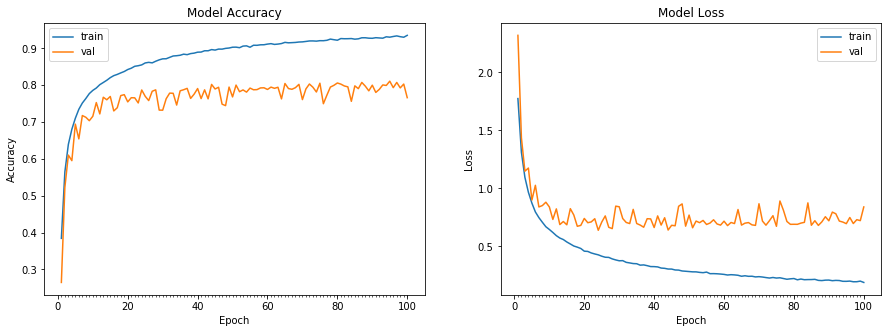

Accuracy on test data is: 76.61


In [22]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
#model.add(Dropout(0.05))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(64, 3, 3))   #12
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=(2, 2))) # 6
#model.add(Dropout(0.25))

model.add(Convolution2D(32, 1, 1)) #6
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3)) #4
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(32, 1, 1)) #4
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(32, 3, 3))   # 1
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(10, 1, 1))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
========
The Model is definitely not looking good as

1. The charts shows over training scenario

2. The validation accuracy went even further down 

But before I run the model with the best till now and adding a dropout between 0.1 and 0.25 , i would like to do one last and small experiment .

Experiment No -8
===================

This time we will 

1. keep the  dropout same as 0.05    but 

2. bring back the Border_Mode

Let's see how it goes. 



W0827 13:44:07.435535 139723844511616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
W0827 13:44:07.483508 139723844511616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0827 13:44:07.496473 139723844511616 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0827 13:44:07.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_2 (Dropout)          (None, 30, 30, 64)        0         
__________

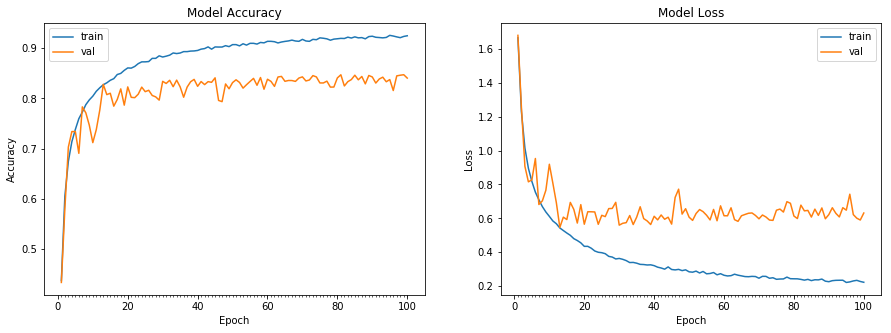

Accuracy on test data is: 84.05


In [7]:
model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
#model.add(Dropout(0.05))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(64, 3, 3,border_mode='same'))   #14
# model.add(BatchNormalization())
# model.add(Dropout(0.25))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=(2, 2))) # 7
#model.add(Dropout(0.25))

model.add(Convolution2D(32, 1, 1)) #7
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #7
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(128, 3, 3))   # 5
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(32, 1, 1)) #5
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(32, 5, 5))   # 1
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(10, 1, 1))   # 1
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
==========
The Model is much better

The charts shows a great improvement

1. The Difference between the Training and validation accuracy is down .

2. The loss between the training and validation accuracy is also down 

The highest validation accuracy is also 84.93 % which is greater than the expected . This tells that the border_mode is definitely having an impact . it reduces the over training even with small drop out value . 

Now we are ready to test the final one which is 0.15 drop out  and see how it behaves 

Experiment No -9
===================

Before we move to the final one , I am wondering is the model over training as we are taking a lot of kernels ? This is probably not the reason , but let's experiment and see how different it's when it comes to lowering down the parameters . So what we did here is 

1. Took less number of kernels every layer 

2. Made good use of transition blocks 

let's see what the output looks like

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(24, (3, 3), input_shape=(32, 32, 3...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:38: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/u

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 30, 30, 24)        672       
_________________________________________________________________
batch_normalization_11 (Batc (None, 30, 30, 24)        96        
_________________________________________________________________
dropout_11 (Dropout)         (None, 30, 30, 24)        0         
_________________________________________________________________
activation_13 (Activation)   (None, 30, 30, 24)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 32)        6944      
_________________________________________________________________
batch_normalization_12 (Batc (None, 28, 28, 32)        128       
_________________________________________________________________
dropout_12 (Dropout)         (None, 28, 28, 32)        0         
__________

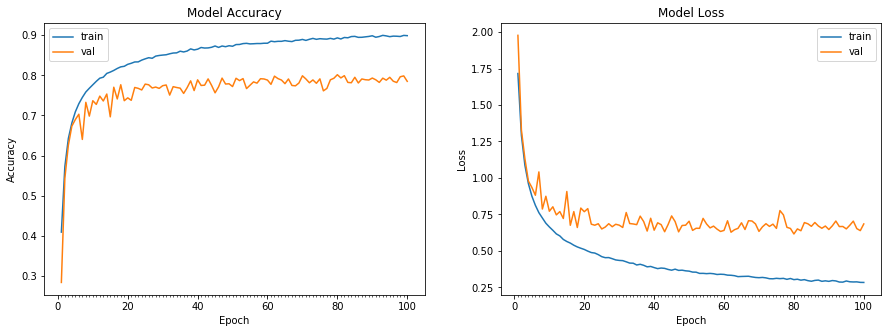

Accuracy on test data is: 78.50


In [8]:
model = Sequential()

model.add(Convolution2D(24, 3, 3, input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(32, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
#model.add(Dropout(0.05))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(64, 3, 3))   #12
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))



model.add(MaxPooling2D(pool_size=(2, 2))) # 6
#model.add(Dropout(0.25))

model.add(Convolution2D(32, 1, 1)) #6
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3)) #4
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))


model.add(Convolution2D(32, 1, 1))   # 4
model.add(BatchNormalization())
model.add(Dropout(0.05))
model.add(Activation('relu'))

model.add(Convolution2D(10, 3, 3))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
==========
The Model is definitely not great as it didn't even tough 80% of the validation accuracy .

The model is not over trained a lot as the charts shows a lot of similarity with the base network . But still the charts are bad compared to the previous model. 

So we can assume that as CIFAR 10 is a complex dataset , so we should spend a little more on the parameters . So we are now all set to experiment the last model and see if it really helps us achieve a balalnced output 

Experiment No -10
===================

This final experiment uses the network from Experiment 7 . The only change made to this network is the dropout percent from 10% to 15 % . 

Let's see if this model gives a good balanced output 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(128, (3, 3))`
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:26: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (1, 1))`
/usr/local/lib/python3.6/dist-pa

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_20 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
dropout_19 (Dropout)         (None, 32, 32, 32)        0         
_________________________________________________________________
activation_23 (Activation)   (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 30, 30, 64)        18496     
_________________________________________________________________
batch_normalization_21 (Batc (None, 30, 30, 64)        256       
_________________________________________________________________
dropout_20 (Dropout)         (None, 30, 30, 64)        0         
__________

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, steps_per_epoch=390, epochs=100)`


Epoch 1/100
390/390 [==============================] - 43s 111ms/step - loss: 1.7186 - acc: 0.4110 - val_loss: 1.9457 - val_acc: 0.3185
Epoch 2/100
390/390 [==============================] - 40s 102ms/step - loss: 1.2764 - acc: 0.5771 - val_loss: 1.4640 - val_acc: 0.4873
Epoch 3/100
390/390 [==============================] - 40s 102ms/step - loss: 1.0697 - acc: 0.6453 - val_loss: 1.0699 - val_acc: 0.6343
Epoch 4/100
390/390 [==============================] - 40s 102ms/step - loss: 0.9499 - acc: 0.6827 - val_loss: 1.1072 - val_acc: 0.6222
Epoch 5/100
390/390 [==============================] - 40s 103ms/step - loss: 0.8615 - acc: 0.7120 - val_loss: 0.9065 - val_acc: 0.6864
Epoch 6/100
390/390 [==============================] - 40s 102ms/step - loss: 0.7951 - acc: 0.7339 - val_loss: 1.0027 - val_acc: 0.6545
Epoch 7/100
390/390 [==============================] - 40s 102ms/step - loss: 0.7461 - acc: 0.7508 - val_loss: 0.8335 - val_acc: 0.7130
Epoch 8/100
390/390 [===========================

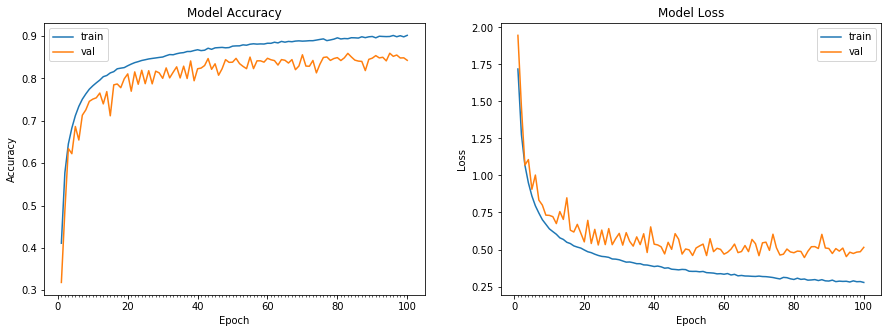

Accuracy on test data is: 84.25


In [9]:
model = Sequential()
model.add(Convolution2D(32, 3, 3, border_mode='same', input_shape=(32, 32, 3)))  # 32
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3))                # 30
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))                # 28
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))


model.add(MaxPooling2D(pool_size=(2, 2)))        # 14
model.add(Dropout(0.15))

model.add(Convolution2D(32, 1, 1)) #14
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #14
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(MaxPooling2D(pool_size=(2, 2))) # 7
model.add(Dropout(0.15))

model.add(Convolution2D(32, 1, 1)) #7
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(64, 3, 3, border_mode='same')) #7
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(128, 3, 3))   #5
model.add(Dropout(0.15))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Convolution2D(32, 1, 1)) #5
model.add(BatchNormalization())
model.add(Dropout(0.15))
model.add(Activation('relu'))

model.add(Convolution2D(10, 5, 5))   # 1
model.add(BatchNormalization())
model.add(Activation('relu'))



model.add(Flatten())
model.add(Activation('softmax'))
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#
model.summary()

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False)


# train the model
start = time.time()
# Train the model
model_info = model.fit_generator(datagen.flow(train_features, train_labels, batch_size = 128),
                                 samples_per_epoch = train_features.shape[0], nb_epoch = 100, 
                                 validation_data = (test_features, test_labels), verbose=1)
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))
# plot model history
plot_model_history(model_info)
# compute test accuracy
print ("Accuracy on test data is: %0.2f"%accuracy(test_features, test_labels, model))

Outcome
============
Let's first look at the graphs . it definitely looks better than before .

1. The validation Accuracy  is almost in the same range of train accuracy . But not as smooth as training accuracy . 

2. The Validation loss also follows the same type of behaviour 
3. Now if we see the validation accuracy then the highest one is 85.92 % which was achieved in the 95th nd epoch. DOes this mean that if we run this code for few more epochs then we will cross 86 % ? At the same time we can see that the model's accuracy is over the 84 % in many epochs 

4. Is this model still over trained ? May be /may be not . As this is subjective with whom should we compare to take the decision ? I dont think we should compare with the base model as we know that it's not a perfect model 

Again why are there so many spikes in the loss ? Does this mean that there are oscillations while trying to achieve the minimum ? Is this due to the default learning rate ?

Let's keep these questions for our further analysis .we will try to revisit this experiment when we start experimenting on the learning rate . As learning rate plays a key role , i am hopeful that it will show some improvements .

Summary 
=============

We ran 10 experiments in this session to see how each function , funtion with different proportion of hyper parameters , with different sequences impacts the network .

I am not going to make any one liner understanding of the over all experiments as every experiment here conveyed a different outcome . 

Having said that here are some experiments which showed ( probably ) better performance than others .



Experiment 4 
===================
1.	Validation Accuracy – 84.02 %
2.	Train /Validation difference in accuracy – around 3 %

**Key Functions** 
1.	Dropout of 0.1 after every convolution step
2.	Batch Normalization after each step
3.	Effective use of transition blocks
4.	Border mode in few places
5.	Final kernel size of 5 x 5
6.	Optimizer = SGD
7.	Normalized image 


Experiment 10
=================
3.	Validation Accuracy – 85.92 %
4.	Train /Validation difference in accuracy – around 4 %

**Key Functions** 

8.	Dropout of 0.15 after every convolution step
9.	Batch Normalization after each step
10.	Effective use of transition blocks
11.	Less number of kernels compared to all other networks
12.	Border mode in few places
13.	Final kernel size of 5 x 5
14.	Optimizer = adam
15.	Normalized image 



Key Note 
============
1. I want to try other hyper parameters as quickly as possible to see how this network behaves/improves 

2. What is the state of the art performance for this dataset ? 

3. Is the Experiment 4 & 10 are still over fitting ? If yes then how much ?


**********************************************************   End of File ********************************************************



